In [39]:
import torch

In [55]:
x = tch.randn(1, requires_grad=True)
x

tensor([-0.1468], requires_grad=True)

In [56]:
print(x.grad)

None


In [57]:
y = x.sum()

In [58]:
y.backward()

In [44]:
print(x.grad)

tensor([1.])


In [45]:
# Set our random seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

Number of examples: 100
Number of features: 2


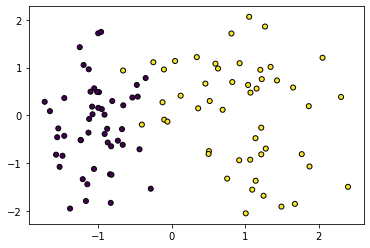

In [63]:
from sklearn.datasets import make_classification
set_seed(7)
X, Y = make_classification(n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1)
print('Number of examples: %d' % X.shape[0])
print('Number of features: %d' % X.shape[1])

# Take a peak
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=25, edgecolor='k')
plt.show()

In [64]:
# Convert data to PyTorch
X, Y = torch.from_numpy(X), torch.from_numpy(Y)

X, Y = X.float(), Y.float()

In [65]:
# Define dimensions
num_feats = 2
hidden_size = 100
num_outputs = 1

# Learning rate
eta = 0.1
num_steps = 1000

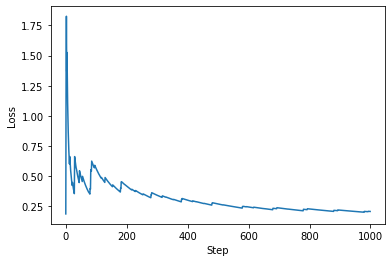

In [68]:
W1 = torch.randn(hidden_size, num_feats, requires_grad=True)
b1 = torch.zeros(hidden_size, requires_grad=True)

W2 = torch.randn(num_outputs, hidden_size, requires_grad=True)
b2 = torch.zeros(num_outputs, requires_grad=True)

parameters = [W1, b1, W2, b2]

indices = torch.randperm(X.size(0))

avg_loss = []


for step in range(num_steps):
    # get example
    i = indices[step % indices.size(0)]
    x_i, y_i = X[i], Y[i]
    
    # run example
    hidden = torch.relu(W1.matmul(x_i) + b1)
    y_hat = torch.sigmoid(W2.matmul(hidden) + b2)
    
    # compute loss binary cross entropy
    # epsilon for numeric stabulity
    eps = 1e-6
    loss = -(y_i * (y_hat + eps).log() + (1 - y_i) * (1 - y_hat + eps).log())
    
    if step == 0:
        avg_loss.append(loss.item())
    else:
        old_avg = avg_loss[-1]
        new_avg = (loss.item() + old_avg * len(avg_loss)) / (len(avg_loss) + 1)
        avg_loss.append(new_avg)
        
    # zero out all previous gradients
    for param in parameters:
       # it might start out as None
        if param.grad is not None:
            param.grad.zero_()
            
    # backward pass
    loss.backward()
    
    # update paramters
    for param in parameters:
        # in place
        param.data = param.data - eta * param.grad
        
plt.plot(range(num_steps), avg_loss)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

### torch.nn

### Layers

In [72]:
import torch.nn as nn

# linear layer: in_feat, out_feat
linear = nn.Linear(in_features=10, out_features=10)
print(linear)

# convolution layer: in channel, out channels, kernel_size, stride
conv = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
print(conv)

# RNN: num_inpnuts, num_hidden, num_layers
rnn = nn.RNN(input_size=10, hidden_size=10, num_layers=1)
print(rnn)

Linear(in_features=10, out_features=10, bias=True)
Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
RNN(10, 10)


In [74]:
print(linear.weight)
print([k for k,v in conv.named_parameters()])

Parameter containing:
tensor([[ 0.0148, -0.1137, -0.2674, -0.1787, -0.2336, -0.2009, -0.0984, -0.1076,
          0.0591, -0.3035],
        [ 0.1645,  0.1325,  0.0672,  0.0039, -0.1924, -0.2925, -0.0037,  0.0579,
          0.0255,  0.0336],
        [-0.2195,  0.2117, -0.2250,  0.2335, -0.2547, -0.2726, -0.0119, -0.1194,
         -0.2016, -0.2053],
        [ 0.2913, -0.2782,  0.0815,  0.2535,  0.1886,  0.2884,  0.0657, -0.2927,
         -0.1732,  0.0370],
        [-0.1063,  0.0385, -0.1573, -0.0819, -0.1728,  0.0328, -0.2432, -0.1218,
          0.1343, -0.0084],
        [ 0.2043, -0.1216,  0.2506, -0.0605,  0.0731, -0.1540,  0.1600,  0.0524,
          0.0792,  0.1853],
        [-0.0596, -0.3153, -0.0856, -0.0782,  0.2762,  0.0345,  0.1579,  0.1695,
         -0.0871, -0.0476],
        [ 0.2534,  0.2895, -0.0121,  0.3015,  0.0896,  0.2883, -0.0159,  0.1936,
          0.1377,  0.1947],
        [ 0.1584,  0.2060, -0.0106, -0.0631, -0.1440, -0.0705,  0.0313, -0.2952,
          0.2328,  0.2947

In [81]:
import torch.nn.functional as F

In [90]:
# Make our own model!

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input channel to 20 feature maps of 5x5 kernel. Stride 1.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        # Full connected of final 4x4 image to 500 features
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        
        # 500 to 10 classes
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

formula fro computing the sizes:

$$
W_f =\frac{W_i - F + 2p}{S} +1
$$

usually, $p = 0$:
$$
W_f =\frac{W_i - F}{S} +1
$$

if $F = S$:
$$
W_f =\frac{W_i }{S}
$$    

### Optimizers

In [91]:
import torch.optim as optim

# initialize with model parameters
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Full train and test loops

In [93]:
import tqdm
import torch.nn.functional as F

def train(model, train_loader, optimizer, epoch):
    
    model.train()
    
    # Avg_loss
    total_loss = 0
    
    #iterate through dataset
    for data, target in tqdm.tqdm(train_loader):
        # zero grad
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # negative log-likeihood loss function
        loss = F.nll_loss(output, target)
        
        # Backward pass
        loss.backward()
        total_loss += loss.item()
        
        # update
        optimizer.step()
        
    print("Train Epoch: {}\t Loss: {:.6f}".format(epoch, total_loss / len(train_loader)))

Testing loops are similar

In [99]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() #sum up bactch loss
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    

### MNIST
now running mnist

In [100]:
from torchvision import datasets, transforms

# see the torch Dataloader for more details
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(    
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=32, shuffle=True)

for epoch in range(1, 10 + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)



  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|▏                                                                                | 3/1875 [00:00<01:22, 22.73it/s]

  0%|▎                                                                                | 6/1875 [00:00<01:23, 22.43it/s]

  0%|▍                                                                                | 9/1875 [00:00<01:24, 22.07it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:25, 21.88it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:27, 21.21it/s]

  1%|▋                                                                               | 16/1875 [00:00<01:29, 20.77it/s]

  1%|▊                                                                               | 19/1875 [00:00<01:28, 20.97it/s]

  1%|▉                        

  8%|██████▎                                                                        | 149/1875 [00:08<01:33, 18.56it/s]

  8%|██████▎                                                                        | 151/1875 [00:09<01:31, 18.92it/s]

  8%|██████▍                                                                        | 153/1875 [00:09<01:30, 19.01it/s]

  8%|██████▌                                                                        | 156/1875 [00:09<01:27, 19.56it/s]

  8%|██████▋                                                                        | 158/1875 [00:09<01:30, 19.07it/s]

  9%|██████▋                                                                        | 160/1875 [00:09<01:30, 18.96it/s]

  9%|██████▊                                                                        | 162/1875 [00:09<01:30, 18.83it/s]

  9%|██████▉                                                                        | 164/1875 [00:09<01:31, 18.68it/s]

  9%|███████                    

 18%|██████████████▍                                                                | 343/1875 [00:18<01:13, 20.77it/s]

 18%|██████████████▌                                                                | 346/1875 [00:18<01:13, 20.92it/s]

 19%|██████████████▋                                                                | 349/1875 [00:18<01:11, 21.30it/s]

 19%|██████████████▊                                                                | 352/1875 [00:18<01:10, 21.52it/s]

 19%|██████████████▉                                                                | 355/1875 [00:18<01:10, 21.59it/s]

 19%|███████████████                                                                | 358/1875 [00:18<01:09, 21.73it/s]

 19%|███████████████▏                                                               | 361/1875 [00:19<01:09, 21.83it/s]

 19%|███████████████▎                                                               | 364/1875 [00:19<01:08, 21.90it/s]

 20%|███████████████▍           

 29%|██████████████████████▉                                                        | 544/1875 [00:27<01:04, 20.76it/s]

 29%|███████████████████████                                                        | 547/1875 [00:27<01:03, 20.83it/s]

 29%|███████████████████████▏                                                       | 550/1875 [00:27<01:03, 20.88it/s]

 29%|███████████████████████▎                                                       | 553/1875 [00:28<01:02, 21.26it/s]

 30%|███████████████████████▍                                                       | 556/1875 [00:28<01:01, 21.50it/s]

 30%|███████████████████████▌                                                       | 559/1875 [00:28<01:01, 21.57it/s]

 30%|███████████████████████▋                                                       | 562/1875 [00:28<01:00, 21.58it/s]

 30%|███████████████████████▊                                                       | 565/1875 [00:28<01:00, 21.72it/s]

 30%|███████████████████████▉   

 37%|█████████████████████████████▏                                                 | 693/1875 [00:35<01:05, 17.92it/s]

 37%|█████████████████████████████▎                                                 | 695/1875 [00:35<01:05, 17.91it/s]

 37%|█████████████████████████████▎                                                 | 697/1875 [00:35<01:04, 18.14it/s]

 37%|█████████████████████████████▍                                                 | 699/1875 [00:35<01:09, 16.82it/s]

 37%|█████████████████████████████▌                                                 | 701/1875 [00:36<01:10, 16.57it/s]

 37%|█████████████████████████████▌                                                 | 703/1875 [00:36<01:08, 17.07it/s]

 38%|█████████████████████████████▋                                                 | 705/1875 [00:36<01:06, 17.48it/s]

 38%|█████████████████████████████▊                                                 | 707/1875 [00:36<01:05, 17.78it/s]

 38%|███████████████████████████

 45%|███████████████████████████████████▌                                           | 843/1875 [00:43<00:51, 20.01it/s]

 45%|███████████████████████████████████▋                                           | 846/1875 [00:43<00:51, 20.01it/s]

 45%|███████████████████████████████████▊                                           | 849/1875 [00:43<00:51, 20.09it/s]

 45%|███████████████████████████████████▉                                           | 852/1875 [00:43<00:49, 20.56it/s]

 46%|████████████████████████████████████                                           | 855/1875 [00:44<00:48, 20.90it/s]

 46%|████████████████████████████████████▏                                          | 858/1875 [00:44<00:48, 21.10it/s]

 46%|████████████████████████████████████▎                                          | 861/1875 [00:44<00:48, 21.11it/s]

 46%|████████████████████████████████████▍                                          | 864/1875 [00:44<00:47, 21.34it/s]

 46%|███████████████████████████

 53%|█████████████████████████████████████████▋                                    | 1001/1875 [00:52<00:46, 18.87it/s]

 53%|█████████████████████████████████████████▋                                    | 1003/1875 [00:52<00:45, 19.04it/s]

 54%|█████████████████████████████████████████▊                                    | 1005/1875 [00:52<00:46, 18.83it/s]

 54%|█████████████████████████████████████████▉                                    | 1007/1875 [00:52<00:46, 18.73it/s]

 54%|██████████████████████████████████████████                                    | 1010/1875 [00:52<00:44, 19.25it/s]

 54%|██████████████████████████████████████████                                    | 1012/1875 [00:52<00:45, 19.13it/s]

 54%|██████████████████████████████████████████▏                                   | 1014/1875 [00:52<00:45, 18.73it/s]

 54%|██████████████████████████████████████████▎                                   | 1016/1875 [00:53<00:46, 18.36it/s]

 54%|███████████████████████████

 61%|███████████████████████████████████████████████▎                              | 1138/1875 [01:00<00:49, 14.78it/s]

 61%|███████████████████████████████████████████████▍                              | 1140/1875 [01:00<00:48, 15.23it/s]

 61%|███████████████████████████████████████████████▌                              | 1142/1875 [01:00<00:47, 15.42it/s]

 61%|███████████████████████████████████████████████▌                              | 1144/1875 [01:00<00:46, 15.70it/s]

 61%|███████████████████████████████████████████████▋                              | 1146/1875 [01:00<00:46, 15.83it/s]

 61%|███████████████████████████████████████████████▊                              | 1148/1875 [01:00<00:45, 15.96it/s]

 61%|███████████████████████████████████████████████▊                              | 1150/1875 [01:00<00:44, 16.13it/s]

 61%|███████████████████████████████████████████████▉                              | 1152/1875 [01:00<00:44, 16.17it/s]

 62%|███████████████████████████

 68%|████████████████████████████████████████████████████▉                         | 1272/1875 [01:08<00:37, 16.20it/s]

 68%|████████████████████████████████████████████████████▉                         | 1274/1875 [01:08<00:37, 16.14it/s]

 68%|█████████████████████████████████████████████████████                         | 1276/1875 [01:08<00:36, 16.46it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1278/1875 [01:08<00:35, 16.69it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1280/1875 [01:08<00:35, 16.94it/s]

 68%|█████████████████████████████████████████████████████▎                        | 1282/1875 [01:09<00:34, 17.03it/s]

 68%|█████████████████████████████████████████████████████▍                        | 1284/1875 [01:09<00:34, 17.14it/s]

 69%|█████████████████████████████████████████████████████▍                        | 1286/1875 [01:09<00:34, 17.00it/s]

 69%|███████████████████████████

 75%|██████████████████████████████████████████████████████████▍                   | 1406/1875 [01:16<00:26, 17.55it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 1408/1875 [01:16<00:26, 17.64it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 1410/1875 [01:17<00:26, 17.76it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 1412/1875 [01:17<00:25, 18.28it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 1414/1875 [01:17<00:27, 16.95it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 1416/1875 [01:17<00:26, 17.13it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 1418/1875 [01:17<00:25, 17.62it/s]

 76%|███████████████████████████████████████████████████████████                   | 1420/1875 [01:17<00:25, 17.74it/s]

 76%|███████████████████████████

 83%|████████████████████████████████████████████████████████████████▋             | 1556/1875 [01:25<00:16, 19.08it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1559/1875 [01:25<00:16, 19.69it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1561/1875 [01:25<00:16, 19.50it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1564/1875 [01:25<00:15, 20.24it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1567/1875 [01:25<00:15, 20.50it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1570/1875 [01:25<00:14, 20.64it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1573/1875 [01:26<00:14, 20.92it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1576/1875 [01:26<00:14, 21.07it/s]

 84%|███████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▉     | 1753/1875 [01:34<00:06, 19.98it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1755/1875 [01:34<00:06, 19.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1757/1875 [01:34<00:06, 19.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1760/1875 [01:35<00:05, 20.13it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1763/1875 [01:35<00:05, 20.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1766/1875 [01:35<00:05, 20.95it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1769/1875 [01:35<00:05, 21.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1772/1875 [01:35<00:04, 21.31it/s]

 95%|███████████████████████████

Train Epoch: 1	 Loss: 0.060761

Test set: Average loss: 0.0474, Accuracy: 9841/10000 (98%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:39, 18.87it/s]

  0%|▏                                                                                | 5/1875 [00:00<01:34, 19.81it/s]

  0%|▎                                                                                | 8/1875 [00:00<01:31, 20.48it/s]

  1%|▍                                                                               | 11/1875 [00:00<01:28, 20.97it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:27, 21.34it/s]

  1%|▋                                                                               | 17/1875 [00:00<01:26, 21.46it/s]

  1%|▊                                                                               | 20/1875 [00:00<01:25, 21.73it/s]

  1%|▉                        

 11%|████████▍                                                                      | 200/1875 [00:09<01:20, 20.90it/s]

 11%|████████▌                                                                      | 203/1875 [00:09<01:20, 20.84it/s]

 11%|████████▋                                                                      | 206/1875 [00:09<01:19, 20.93it/s]

 11%|████████▊                                                                      | 209/1875 [00:09<01:18, 21.26it/s]

 11%|████████▉                                                                      | 212/1875 [00:09<01:17, 21.36it/s]

 11%|█████████                                                                      | 215/1875 [00:10<01:17, 21.33it/s]

 12%|█████████▏                                                                     | 218/1875 [00:10<01:17, 21.46it/s]

 12%|█████████▎                                                                     | 221/1875 [00:10<01:16, 21.54it/s]

 12%|█████████▍                 

 19%|██████████████▉                                                                | 355/1875 [00:17<01:26, 17.49it/s]

 19%|███████████████                                                                | 357/1875 [00:17<01:26, 17.50it/s]

 19%|███████████████▏                                                               | 360/1875 [00:17<01:21, 18.49it/s]

 19%|███████████████▎                                                               | 363/1875 [00:17<01:19, 19.10it/s]

 20%|███████████████▍                                                               | 366/1875 [00:18<01:16, 19.71it/s]

 20%|███████████████▌                                                               | 368/1875 [00:18<01:18, 19.28it/s]

 20%|███████████████▋                                                               | 371/1875 [00:18<01:15, 19.96it/s]

 20%|███████████████▊                                                               | 374/1875 [00:18<01:14, 20.26it/s]

 20%|███████████████▉           

 27%|█████████████████████▎                                                         | 507/1875 [00:25<01:11, 19.05it/s]

 27%|█████████████████████▍                                                         | 509/1875 [00:25<01:12, 18.89it/s]

 27%|█████████████████████▌                                                         | 512/1875 [00:25<01:09, 19.48it/s]

 27%|█████████████████████▋                                                         | 515/1875 [00:25<01:07, 20.19it/s]

 28%|█████████████████████▊                                                         | 518/1875 [00:26<01:06, 20.42it/s]

 28%|█████████████████████▉                                                         | 521/1875 [00:26<01:05, 20.63it/s]

 28%|██████████████████████                                                         | 524/1875 [00:26<01:04, 20.82it/s]

 28%|██████████████████████▏                                                        | 527/1875 [00:26<01:04, 21.05it/s]

 28%|██████████████████████▎    

 38%|█████████████████████████████▋                                                 | 706/1875 [00:35<00:58, 20.14it/s]

 38%|█████████████████████████████▊                                                 | 709/1875 [00:35<00:58, 19.79it/s]

 38%|█████████████████████████████▉                                                 | 711/1875 [00:35<01:01, 18.79it/s]

 38%|██████████████████████████████                                                 | 713/1875 [00:35<01:03, 18.25it/s]

 38%|██████████████████████████████▏                                                | 715/1875 [00:35<01:04, 17.89it/s]

 38%|██████████████████████████████▏                                                | 717/1875 [00:35<01:07, 17.14it/s]

 38%|██████████████████████████████▎                                                | 719/1875 [00:35<01:10, 16.50it/s]

 38%|██████████████████████████████▍                                                | 721/1875 [00:36<01:14, 15.58it/s]

 39%|███████████████████████████

 47%|█████████████████████████████████████▍                                         | 889/1875 [00:44<00:46, 21.24it/s]

 48%|█████████████████████████████████████▌                                         | 892/1875 [00:44<00:45, 21.67it/s]

 48%|█████████████████████████████████████▋                                         | 895/1875 [00:44<00:46, 21.10it/s]

 48%|█████████████████████████████████████▊                                         | 898/1875 [00:44<00:45, 21.33it/s]

 48%|█████████████████████████████████████▉                                         | 901/1875 [00:44<00:45, 21.50it/s]

 48%|██████████████████████████████████████                                         | 904/1875 [00:45<00:45, 21.44it/s]

 48%|██████████████████████████████████████▏                                        | 907/1875 [00:45<00:45, 21.30it/s]

 49%|██████████████████████████████████████▎                                        | 910/1875 [00:45<00:44, 21.48it/s]

 49%|███████████████████████████

 58%|█████████████████████████████████████████████▎                                | 1090/1875 [00:53<00:36, 21.36it/s]

 58%|█████████████████████████████████████████████▍                                | 1093/1875 [00:53<00:38, 20.46it/s]

 58%|█████████████████████████████████████████████▌                                | 1096/1875 [00:53<00:37, 20.58it/s]

 59%|█████████████████████████████████████████████▋                                | 1099/1875 [00:54<00:37, 20.83it/s]

 59%|█████████████████████████████████████████████▊                                | 1102/1875 [00:54<00:36, 21.32it/s]

 59%|█████████████████████████████████████████████▉                                | 1105/1875 [00:54<00:35, 21.63it/s]

 59%|██████████████████████████████████████████████                                | 1108/1875 [00:54<00:37, 20.38it/s]

 59%|██████████████████████████████████████████████▏                               | 1111/1875 [00:54<00:37, 20.52it/s]

 59%|███████████████████████████

 69%|█████████████████████████████████████████████████████▋                        | 1290/1875 [01:03<00:27, 21.20it/s]

 69%|█████████████████████████████████████████████████████▊                        | 1293/1875 [01:03<00:26, 21.64it/s]

 69%|█████████████████████████████████████████████████████▉                        | 1296/1875 [01:03<00:26, 22.00it/s]

 69%|██████████████████████████████████████████████████████                        | 1299/1875 [01:03<00:26, 21.88it/s]

 69%|██████████████████████████████████████████████████████▏                       | 1302/1875 [01:03<00:26, 21.28it/s]

 70%|██████████████████████████████████████████████████████▎                       | 1305/1875 [01:03<00:26, 21.65it/s]

 70%|██████████████████████████████████████████████████████▍                       | 1308/1875 [01:04<00:25, 22.21it/s]

 70%|██████████████████████████████████████████████████████▌                       | 1311/1875 [01:04<00:25, 22.31it/s]

 70%|███████████████████████████

 78%|████████████████████████████████████████████████████████████▌                 | 1457/1875 [01:11<00:22, 18.79it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1459/1875 [01:11<00:22, 18.76it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1461/1875 [01:11<00:23, 17.42it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1463/1875 [01:11<00:23, 17.60it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 1465/1875 [01:12<00:22, 18.06it/s]

 78%|█████████████████████████████████████████████████████████████                 | 1467/1875 [01:12<00:22, 18.05it/s]

 78%|█████████████████████████████████████████████████████████████                 | 1469/1875 [01:12<00:22, 17.94it/s]

 78%|█████████████████████████████████████████████████████████████▏                | 1471/1875 [01:12<00:22, 17.68it/s]

 79%|███████████████████████████

 85%|█████████████████████████████████████████████████████████████████▉            | 1586/1875 [01:20<00:19, 15.19it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1588/1875 [01:20<00:19, 14.91it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1590/1875 [01:21<00:19, 14.43it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1592/1875 [01:21<00:19, 14.61it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1594/1875 [01:21<00:18, 14.83it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1596/1875 [01:21<00:18, 15.27it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1598/1875 [01:21<00:17, 15.85it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1600/1875 [01:21<00:16, 16.45it/s]

 85%|███████████████████████████

 92%|███████████████████████████████████████████████████████████████████████▌      | 1720/1875 [01:29<00:09, 15.68it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1722/1875 [01:29<00:09, 15.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1724/1875 [01:29<00:09, 15.48it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1726/1875 [01:29<00:09, 15.63it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1728/1875 [01:29<00:08, 16.56it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1730/1875 [01:29<00:08, 17.24it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1732/1875 [01:30<00:08, 17.70it/s]

 92%|████████████████████████████████████████████████████████████████████████▏     | 1734/1875 [01:30<00:07, 17.99it/s]

 93%|███████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1859/1875 [01:36<00:00, 17.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1861/1875 [01:37<00:00, 17.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1863/1875 [01:37<00:00, 17.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1865/1875 [01:37<00:00, 17.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1867/1875 [01:37<00:00, 18.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1869/1875 [01:37<00:00, 18.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1871/1875 [01:37<00:00, 18.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1873/1875 [01:37<00:00, 18.69it/s]

100%|███████████████████████████

Train Epoch: 2	 Loss: 0.048095

Test set: Average loss: 0.0367, Accuracy: 9884/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:45, 17.70it/s]

  0%|▏                                                                                | 4/1875 [00:00<01:48, 17.29it/s]

  0%|▎                                                                                | 6/1875 [00:00<01:45, 17.69it/s]

  0%|▍                                                                                | 9/1875 [00:00<01:39, 18.74it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:36, 19.40it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:37, 19.13it/s]

  1%|▋                                                                               | 16/1875 [00:00<01:39, 18.68it/s]

  1%|▊                        

  7%|█████▊                                                                         | 138/1875 [00:08<02:19, 12.47it/s]

  7%|█████▉                                                                         | 140/1875 [00:08<02:18, 12.51it/s]

  8%|█████▉                                                                         | 142/1875 [00:09<02:14, 12.84it/s]

  8%|██████                                                                         | 144/1875 [00:09<02:17, 12.59it/s]

  8%|██████▏                                                                        | 146/1875 [00:09<02:20, 12.31it/s]

  8%|██████▏                                                                        | 148/1875 [00:09<02:34, 11.15it/s]

  8%|██████▎                                                                        | 150/1875 [00:09<02:29, 11.50it/s]

  8%|██████▍                                                                        | 152/1875 [00:09<02:23, 12.00it/s]

  8%|██████▍                    

 14%|███████████▍                                                                   | 270/1875 [00:18<05:15,  5.09it/s]

 14%|███████████▍                                                                   | 271/1875 [00:18<04:44,  5.65it/s]

 15%|███████████▌                                                                   | 273/1875 [00:18<03:56,  6.78it/s]

 15%|███████████▌                                                                   | 275/1875 [00:18<03:18,  8.06it/s]

 15%|███████████▋                                                                   | 277/1875 [00:18<02:47,  9.55it/s]

 15%|███████████▊                                                                   | 279/1875 [00:18<02:25, 10.93it/s]

 15%|███████████▊                                                                   | 281/1875 [00:19<03:41,  7.20it/s]

 15%|███████████▉                                                                   | 283/1875 [00:19<03:26,  7.70it/s]

 15%|████████████               

 21%|████████████████▍                                                              | 391/1875 [00:28<01:39, 14.91it/s]

 21%|████████████████▌                                                              | 393/1875 [00:28<01:33, 15.83it/s]

 21%|████████████████▋                                                              | 395/1875 [00:29<01:31, 16.23it/s]

 21%|████████████████▋                                                              | 397/1875 [00:29<01:29, 16.57it/s]

 21%|████████████████▊                                                              | 399/1875 [00:29<01:27, 16.89it/s]

 21%|████████████████▉                                                              | 401/1875 [00:29<01:26, 17.08it/s]

 21%|████████████████▉                                                              | 403/1875 [00:29<01:25, 17.13it/s]

 22%|█████████████████                                                              | 405/1875 [00:29<01:25, 17.21it/s]

 22%|█████████████████▏         

 29%|███████████████████████                                                        | 546/1875 [00:37<01:10, 18.87it/s]

 29%|███████████████████████▏                                                       | 549/1875 [00:37<01:07, 19.57it/s]

 29%|███████████████████████▏                                                       | 551/1875 [00:37<01:07, 19.47it/s]

 30%|███████████████████████▎                                                       | 554/1875 [00:37<01:05, 20.10it/s]

 30%|███████████████████████▍                                                       | 557/1875 [00:37<01:03, 20.61it/s]

 30%|███████████████████████▌                                                       | 560/1875 [00:37<01:03, 20.77it/s]

 30%|███████████████████████▋                                                       | 563/1875 [00:37<01:02, 21.05it/s]

 30%|███████████████████████▊                                                       | 566/1875 [00:38<01:01, 21.25it/s]

 30%|███████████████████████▉   

 40%|███████████████████████████████▍                                               | 746/1875 [00:46<00:55, 20.32it/s]

 40%|███████████████████████████████▌                                               | 749/1875 [00:46<00:55, 20.26it/s]

 40%|███████████████████████████████▋                                               | 752/1875 [00:47<00:54, 20.47it/s]

 40%|███████████████████████████████▊                                               | 755/1875 [00:47<00:53, 20.80it/s]

 40%|███████████████████████████████▉                                               | 758/1875 [00:47<00:53, 21.03it/s]

 41%|████████████████████████████████                                               | 761/1875 [00:47<00:53, 20.84it/s]

 41%|████████████████████████████████▏                                              | 764/1875 [00:47<00:54, 20.29it/s]

 41%|████████████████████████████████▎                                              | 767/1875 [00:47<00:53, 20.62it/s]

 41%|███████████████████████████

 50%|███████████████████████████████████████▋                                       | 941/1875 [00:56<00:48, 19.45it/s]

 50%|███████████████████████████████████████▊                                       | 944/1875 [00:56<00:46, 20.00it/s]

 51%|███████████████████████████████████████▉                                       | 947/1875 [00:56<00:45, 20.21it/s]

 51%|████████████████████████████████████████                                       | 950/1875 [00:56<00:44, 20.56it/s]

 51%|████████████████████████████████████████▏                                      | 953/1875 [00:56<00:44, 20.86it/s]

 51%|████████████████████████████████████████▎                                      | 956/1875 [00:56<00:43, 21.12it/s]

 51%|████████████████████████████████████████▍                                      | 959/1875 [00:57<00:43, 21.21it/s]

 51%|████████████████████████████████████████▌                                      | 962/1875 [00:57<00:42, 21.32it/s]

 51%|███████████████████████████

 61%|███████████████████████████████████████████████▌                              | 1142/1875 [01:05<00:36, 20.14it/s]

 61%|███████████████████████████████████████████████▋                              | 1145/1875 [01:06<00:36, 19.98it/s]

 61%|███████████████████████████████████████████████▋                              | 1147/1875 [01:06<00:36, 19.93it/s]

 61%|███████████████████████████████████████████████▊                              | 1150/1875 [01:06<00:35, 20.36it/s]

 61%|███████████████████████████████████████████████▉                              | 1153/1875 [01:06<00:34, 20.75it/s]

 62%|████████████████████████████████████████████████                              | 1156/1875 [01:06<00:34, 20.91it/s]

 62%|████████████████████████████████████████████████▏                             | 1159/1875 [01:06<00:34, 21.02it/s]

 62%|████████████████████████████████████████████████▎                             | 1162/1875 [01:06<00:33, 21.14it/s]

 62%|███████████████████████████

 69%|█████████████████████████████████████████████████████▊                        | 1294/1875 [01:13<00:32, 17.86it/s]

 69%|█████████████████████████████████████████████████████▉                        | 1297/1875 [01:14<00:30, 18.69it/s]

 69%|██████████████████████████████████████████████████████                        | 1299/1875 [01:14<00:30, 18.91it/s]

 69%|██████████████████████████████████████████████████████▏                       | 1302/1875 [01:14<00:29, 19.64it/s]

 70%|██████████████████████████████████████████████████████▏                       | 1304/1875 [01:14<00:29, 19.46it/s]

 70%|██████████████████████████████████████████████████████▎                       | 1306/1875 [01:14<00:29, 19.28it/s]

 70%|██████████████████████████████████████████████████████▍                       | 1309/1875 [01:14<00:28, 19.84it/s]

 70%|██████████████████████████████████████████████████████▌                       | 1311/1875 [01:14<00:28, 19.60it/s]

 70%|███████████████████████████

 77%|███████████████████████████████████████████████████████████▉                  | 1441/1875 [01:21<00:23, 18.82it/s]

 77%|████████████████████████████████████████████████████████████                  | 1443/1875 [01:21<00:23, 18.73it/s]

 77%|████████████████████████████████████████████████████████████                  | 1445/1875 [01:21<00:22, 18.99it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1447/1875 [01:21<00:23, 18.48it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1449/1875 [01:21<00:23, 17.95it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1451/1875 [01:22<00:23, 18.21it/s]

 77%|████████████████████████████████████████████████████████████▍                 | 1453/1875 [01:22<00:23, 18.16it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 1455/1875 [01:22<00:23, 17.68it/s]

 78%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▊            | 1582/1875 [01:29<00:22, 12.86it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 1584/1875 [01:30<00:23, 12.56it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1586/1875 [01:30<00:21, 13.26it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1588/1875 [01:30<00:20, 13.98it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1590/1875 [01:30<00:21, 13.37it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1592/1875 [01:30<00:22, 12.60it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1594/1875 [01:30<00:23, 12.01it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1596/1875 [01:30<00:22, 12.38it/s]

 85%|███████████████████████████

 92%|███████████████████████████████████████████████████████████████████████▍      | 1716/1875 [01:38<00:11, 14.26it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1718/1875 [01:39<00:10, 14.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1720/1875 [01:39<00:10, 15.23it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1722/1875 [01:39<00:09, 15.71it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1724/1875 [01:39<00:09, 16.10it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1726/1875 [01:39<00:09, 16.27it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1728/1875 [01:39<00:08, 16.39it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1730/1875 [01:39<00:08, 16.35it/s]

 92%|███████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████ | 1851/1875 [01:47<00:01, 17.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1853/1875 [01:47<00:01, 17.20it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1855/1875 [01:47<00:01, 17.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1857/1875 [01:47<00:01, 17.00it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1859/1875 [01:47<00:00, 16.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1861/1875 [01:47<00:00, 15.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1863/1875 [01:47<00:00, 15.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1865/1875 [01:47<00:00, 16.34it/s]

100%|███████████████████████████

Train Epoch: 3	 Loss: 0.039202

Test set: Average loss: 0.0349, Accuracy: 9877/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 1/1875 [00:00<03:52,  8.07it/s]

  0%|▏                                                                                | 3/1875 [00:00<03:27,  9.02it/s]

  0%|▏                                                                                | 5/1875 [00:00<02:59, 10.41it/s]

  0%|▎                                                                                | 7/1875 [00:00<02:36, 11.94it/s]

  1%|▍                                                                               | 10/1875 [00:00<02:15, 13.73it/s]

  1%|▌                                                                               | 12/1875 [00:00<02:03, 15.12it/s]

  1%|▋                                                                               | 15/1875 [00:00<01:52, 16.59it/s]

  1%|▊                        

  8%|██████▌                                                                        | 155/1875 [00:08<01:33, 18.47it/s]

  8%|██████▋                                                                        | 158/1875 [00:08<01:28, 19.34it/s]

  9%|██████▊                                                                        | 161/1875 [00:08<01:26, 19.89it/s]

  9%|██████▉                                                                        | 164/1875 [00:09<01:24, 20.25it/s]

  9%|███████                                                                        | 167/1875 [00:09<01:23, 20.46it/s]

  9%|███████▏                                                                       | 170/1875 [00:09<01:22, 20.62it/s]

  9%|███████▎                                                                       | 173/1875 [00:09<01:21, 20.94it/s]

  9%|███████▍                                                                       | 176/1875 [00:09<01:21, 20.96it/s]

 10%|███████▌                   

 18%|█████████████▊                                                                 | 329/1875 [00:17<01:31, 16.84it/s]

 18%|█████████████▉                                                                 | 331/1875 [00:17<01:32, 16.66it/s]

 18%|██████████████                                                                 | 333/1875 [00:17<01:30, 16.96it/s]

 18%|██████████████                                                                 | 335/1875 [00:17<01:31, 16.79it/s]

 18%|██████████████▏                                                                | 337/1875 [00:18<01:32, 16.55it/s]

 18%|██████████████▎                                                                | 339/1875 [00:18<01:31, 16.79it/s]

 18%|██████████████▍                                                                | 342/1875 [00:18<01:25, 17.93it/s]

 18%|██████████████▌                                                                | 345/1875 [00:18<01:21, 18.89it/s]

 19%|██████████████▌            

 26%|████████████████████▎                                                          | 482/1875 [00:25<01:08, 20.28it/s]

 26%|████████████████████▍                                                          | 485/1875 [00:26<01:08, 20.24it/s]

 26%|████████████████████▌                                                          | 488/1875 [00:26<01:08, 20.33it/s]

 26%|████████████████████▋                                                          | 491/1875 [00:26<01:06, 20.74it/s]

 26%|████████████████████▊                                                          | 494/1875 [00:26<01:05, 20.99it/s]

 27%|████████████████████▉                                                          | 497/1875 [00:26<01:04, 21.25it/s]

 27%|█████████████████████                                                          | 500/1875 [00:26<01:04, 21.22it/s]

 27%|█████████████████████▏                                                         | 503/1875 [00:26<01:04, 21.28it/s]

 27%|█████████████████████▎     

 35%|███████████████████████████▊                                                   | 659/1875 [00:34<01:11, 17.00it/s]

 35%|███████████████████████████▊                                                   | 661/1875 [00:35<01:09, 17.38it/s]

 35%|███████████████████████████▉                                                   | 663/1875 [00:35<01:09, 17.48it/s]

 35%|████████████████████████████                                                   | 665/1875 [00:35<01:08, 17.59it/s]

 36%|████████████████████████████                                                   | 667/1875 [00:35<01:08, 17.58it/s]

 36%|████████████████████████████▏                                                  | 669/1875 [00:35<01:08, 17.66it/s]

 36%|████████████████████████████▎                                                  | 671/1875 [00:35<01:08, 17.58it/s]

 36%|████████████████████████████▎                                                  | 673/1875 [00:35<01:08, 17.67it/s]

 36%|███████████████████████████

 45%|███████████████████████████████████▊                                           | 850/1875 [00:44<00:50, 20.46it/s]

 45%|███████████████████████████████████▉                                           | 853/1875 [00:44<00:49, 20.49it/s]

 46%|████████████████████████████████████                                           | 856/1875 [00:44<00:49, 20.68it/s]

 46%|████████████████████████████████████▏                                          | 859/1875 [00:44<00:48, 20.94it/s]

 46%|████████████████████████████████████▎                                          | 862/1875 [00:44<00:47, 21.22it/s]

 46%|████████████████████████████████████▍                                          | 865/1875 [00:45<00:47, 21.47it/s]

 46%|████████████████████████████████████▌                                          | 868/1875 [00:45<00:47, 21.19it/s]

 46%|████████████████████████████████████▋                                          | 871/1875 [00:45<00:47, 21.22it/s]

 47%|███████████████████████████

 56%|███████████████████████████████████████████▍                                  | 1045/1875 [00:53<00:41, 19.90it/s]

 56%|███████████████████████████████████████████▌                                  | 1047/1875 [00:53<00:42, 19.70it/s]

 56%|███████████████████████████████████████████▋                                  | 1050/1875 [00:54<00:40, 20.15it/s]

 56%|███████████████████████████████████████████▊                                  | 1053/1875 [00:54<00:39, 20.56it/s]

 56%|███████████████████████████████████████████▉                                  | 1056/1875 [00:54<00:39, 20.73it/s]

 56%|████████████████████████████████████████████                                  | 1059/1875 [00:54<00:39, 20.76it/s]

 57%|████████████████████████████████████████████▏                                 | 1062/1875 [00:54<00:38, 21.09it/s]

 57%|████████████████████████████████████████████▎                                 | 1065/1875 [00:54<00:38, 21.15it/s]

 57%|███████████████████████████

 66%|███████████████████████████████████████████████████▍                          | 1236/1875 [01:03<00:31, 20.16it/s]

 66%|███████████████████████████████████████████████████▌                          | 1239/1875 [01:03<00:31, 20.15it/s]

 66%|███████████████████████████████████████████████████▋                          | 1242/1875 [01:03<00:31, 20.27it/s]

 66%|███████████████████████████████████████████████████▊                          | 1245/1875 [01:03<00:31, 20.31it/s]

 67%|███████████████████████████████████████████████████▉                          | 1248/1875 [01:03<00:30, 20.72it/s]

 67%|████████████████████████████████████████████████████                          | 1251/1875 [01:03<00:29, 20.89it/s]

 67%|████████████████████████████████████████████████████▏                         | 1254/1875 [01:03<00:29, 21.09it/s]

 67%|████████████████████████████████████████████████████▎                         | 1257/1875 [01:04<00:29, 21.15it/s]

 67%|███████████████████████████

 77%|███████████████████████████████████████████████████████████▊                  | 1437/1875 [01:12<00:21, 20.37it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 1440/1875 [01:12<00:21, 20.38it/s]

 77%|████████████████████████████████████████████████████████████                  | 1443/1875 [01:13<00:20, 20.60it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1446/1875 [01:13<00:21, 20.29it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1449/1875 [01:13<00:20, 20.62it/s]

 77%|████████████████████████████████████████████████████████████▍                 | 1452/1875 [01:13<00:20, 21.04it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 1455/1875 [01:13<00:19, 21.29it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1458/1875 [01:13<00:19, 21.33it/s]

 78%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████████▍           | 1597/1875 [01:21<00:15, 17.61it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1599/1875 [01:21<00:15, 17.41it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1601/1875 [01:21<00:15, 17.41it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 1604/1875 [01:21<00:14, 18.41it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 1607/1875 [01:21<00:13, 19.34it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 1610/1875 [01:22<00:13, 19.61it/s]

 86%|███████████████████████████████████████████████████████████████████           | 1612/1875 [01:22<00:13, 18.89it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 1615/1875 [01:22<00:13, 19.59it/s]

 86%|███████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1788/1875 [01:30<00:04, 18.94it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1790/1875 [01:30<00:04, 18.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1792/1875 [01:30<00:04, 18.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1795/1875 [01:31<00:04, 19.90it/s]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1798/1875 [01:31<00:03, 20.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1801/1875 [01:31<00:03, 20.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1804/1875 [01:31<00:03, 21.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1807/1875 [01:31<00:03, 21.15it/s]

 97%|███████████████████████████

Train Epoch: 4	 Loss: 0.034715

Test set: Average loss: 0.0434, Accuracy: 9865/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<02:03, 15.16it/s]

  0%|▏                                                                                | 4/1875 [00:00<01:57, 15.95it/s]

  0%|▎                                                                                | 6/1875 [00:00<01:53, 16.44it/s]

  0%|▎                                                                                | 8/1875 [00:00<01:50, 16.89it/s]

  1%|▍                                                                               | 10/1875 [00:00<01:48, 17.21it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:47, 17.36it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:46, 17.46it/s]

  1%|▋                        

  8%|█████▉                                                                         | 142/1875 [00:07<01:30, 19.12it/s]

  8%|██████                                                                         | 144/1875 [00:07<01:37, 17.73it/s]

  8%|██████▏                                                                        | 146/1875 [00:07<01:38, 17.54it/s]

  8%|██████▎                                                                        | 149/1875 [00:08<01:33, 18.51it/s]

  8%|██████▍                                                                        | 152/1875 [00:08<01:28, 19.38it/s]

  8%|██████▌                                                                        | 155/1875 [00:08<01:26, 19.95it/s]

  8%|██████▋                                                                        | 158/1875 [00:08<01:23, 20.59it/s]

  9%|██████▊                                                                        | 161/1875 [00:08<01:21, 20.92it/s]

  9%|██████▉                    

 18%|█████████████▊                                                                 | 329/1875 [00:16<01:16, 20.24it/s]

 18%|█████████████▉                                                                 | 332/1875 [00:16<01:16, 20.29it/s]

 18%|██████████████                                                                 | 335/1875 [00:17<01:15, 20.49it/s]

 18%|██████████████▏                                                                | 338/1875 [00:17<01:15, 20.26it/s]

 18%|██████████████▎                                                                | 341/1875 [00:17<01:14, 20.69it/s]

 18%|██████████████▍                                                                | 344/1875 [00:17<01:13, 20.86it/s]

 19%|██████████████▌                                                                | 347/1875 [00:17<01:12, 21.12it/s]

 19%|██████████████▋                                                                | 350/1875 [00:17<01:12, 21.08it/s]

 19%|██████████████▊            

 28%|██████████████████████▏                                                        | 528/1875 [00:26<01:06, 20.25it/s]

 28%|██████████████████████▎                                                        | 531/1875 [00:26<01:06, 20.09it/s]

 28%|██████████████████████▍                                                        | 534/1875 [00:26<01:05, 20.39it/s]

 29%|██████████████████████▋                                                        | 537/1875 [00:26<01:04, 20.65it/s]

 29%|██████████████████████▊                                                        | 540/1875 [00:27<01:03, 20.93it/s]

 29%|██████████████████████▉                                                        | 543/1875 [00:27<01:02, 21.30it/s]

 29%|███████████████████████                                                        | 546/1875 [00:27<01:01, 21.48it/s]

 29%|███████████████████████▏                                                       | 549/1875 [00:27<01:01, 21.60it/s]

 29%|███████████████████████▎   

 37%|█████████████████████████████▌                                                 | 701/1875 [00:35<00:58, 20.09it/s]

 38%|█████████████████████████████▋                                                 | 704/1875 [00:35<00:58, 19.98it/s]

 38%|█████████████████████████████▊                                                 | 707/1875 [00:35<00:57, 20.19it/s]

 38%|█████████████████████████████▉                                                 | 710/1875 [00:35<00:57, 20.18it/s]

 38%|██████████████████████████████                                                 | 713/1875 [00:35<00:57, 20.29it/s]

 38%|██████████████████████████████▏                                                | 716/1875 [00:35<00:56, 20.62it/s]

 38%|██████████████████████████████▎                                                | 719/1875 [00:36<00:55, 20.86it/s]

 39%|██████████████████████████████▍                                                | 722/1875 [00:36<00:56, 20.51it/s]

 39%|███████████████████████████

 47%|█████████████████████████████████████▏                                         | 883/1875 [00:44<00:49, 20.20it/s]

 47%|█████████████████████████████████████▎                                         | 886/1875 [00:44<00:48, 20.18it/s]

 47%|█████████████████████████████████████▍                                         | 889/1875 [00:44<00:48, 20.46it/s]

 48%|█████████████████████████████████████▌                                         | 892/1875 [00:44<00:48, 20.40it/s]

 48%|█████████████████████████████████████▋                                         | 895/1875 [00:45<00:47, 20.70it/s]

 48%|█████████████████████████████████████▊                                         | 898/1875 [00:45<00:46, 20.96it/s]

 48%|█████████████████████████████████████▉                                         | 901/1875 [00:45<00:45, 21.19it/s]

 48%|██████████████████████████████████████                                         | 904/1875 [00:45<00:45, 21.22it/s]

 48%|███████████████████████████

 56%|███████████████████████████████████████████▉                                  | 1056/1875 [00:53<00:48, 16.73it/s]

 56%|████████████████████████████████████████████                                  | 1058/1875 [00:53<00:46, 17.55it/s]

 57%|████████████████████████████████████████████                                  | 1060/1875 [00:53<00:45, 17.97it/s]

 57%|████████████████████████████████████████████▏                                 | 1063/1875 [00:53<00:42, 19.14it/s]

 57%|████████████████████████████████████████████▎                                 | 1066/1875 [00:53<00:40, 19.82it/s]

 57%|████████████████████████████████████████████▍                                 | 1069/1875 [00:53<00:39, 20.28it/s]

 57%|████████████████████████████████████████████▌                                 | 1072/1875 [00:54<00:38, 20.65it/s]

 57%|████████████████████████████████████████████▋                                 | 1075/1875 [00:54<00:38, 20.92it/s]

 57%|███████████████████████████

 67%|████████████████████████████████████████████████████▏                         | 1255/1875 [01:02<00:31, 19.93it/s]

 67%|████████████████████████████████████████████████████▎                         | 1257/1875 [01:03<00:31, 19.60it/s]

 67%|████████████████████████████████████████████████████▎                         | 1259/1875 [01:03<00:31, 19.38it/s]

 67%|████████████████████████████████████████████████████▍                         | 1262/1875 [01:03<00:30, 20.20it/s]

 67%|████████████████████████████████████████████████████▌                         | 1265/1875 [01:03<00:29, 20.77it/s]

 68%|████████████████████████████████████████████████████▋                         | 1268/1875 [01:03<00:29, 20.66it/s]

 68%|████████████████████████████████████████████████████▊                         | 1271/1875 [01:03<00:30, 20.05it/s]

 68%|████████████████████████████████████████████████████▉                         | 1274/1875 [01:03<00:31, 19.15it/s]

 68%|███████████████████████████

 77%|███████████████████████████████████████████████████████████▊                  | 1439/1875 [01:12<00:21, 20.13it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 1442/1875 [01:12<00:21, 20.34it/s]

 77%|████████████████████████████████████████████████████████████                  | 1445/1875 [01:12<00:20, 20.53it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1448/1875 [01:12<00:20, 20.92it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1451/1875 [01:12<00:20, 21.16it/s]

 78%|████████████████████████████████████████████████████████████▍                 | 1454/1875 [01:12<00:19, 21.47it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 1457/1875 [01:12<00:19, 21.60it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1460/1875 [01:13<00:19, 21.55it/s]

 78%|███████████████████████████

 87%|███████████████████████████████████████████████████████████████████▌          | 1624/1875 [01:21<00:13, 19.09it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 1626/1875 [01:21<00:13, 18.92it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 1628/1875 [01:21<00:12, 19.07it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 1631/1875 [01:21<00:12, 19.96it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 1634/1875 [01:21<00:11, 20.46it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1637/1875 [01:21<00:11, 20.66it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1640/1875 [01:21<00:11, 20.97it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 1643/1875 [01:22<00:11, 20.55it/s]

 88%|███████████████████████████

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1812/1875 [01:30<00:03, 18.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1814/1875 [01:30<00:03, 18.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1816/1875 [01:30<00:03, 18.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1818/1875 [01:30<00:03, 18.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1821/1875 [01:30<00:02, 19.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1824/1875 [01:31<00:02, 19.96it/s]

 97%|████████████████████████████████████████████████████████████████████████████  | 1827/1875 [01:31<00:02, 20.30it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1830/1875 [01:31<00:02, 20.76it/s]

 98%|███████████████████████████

Train Epoch: 5	 Loss: 0.030056

Test set: Average loss: 0.0377, Accuracy: 9876/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:44, 17.86it/s]

  0%|▏                                                                                | 5/1875 [00:00<01:39, 18.87it/s]

  0%|▎                                                                                | 7/1875 [00:00<01:38, 18.93it/s]

  0%|▍                                                                                | 9/1875 [00:00<01:39, 18.75it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:35, 19.52it/s]

  1%|▋                                                                               | 15/1875 [00:00<01:32, 20.14it/s]

  1%|▊                                                                               | 18/1875 [00:00<01:29, 20.68it/s]

  1%|▉                        

 11%|████████▎                                                                      | 198/1875 [00:09<01:21, 20.66it/s]

 11%|████████▍                                                                      | 201/1875 [00:09<01:21, 20.62it/s]

 11%|████████▌                                                                      | 204/1875 [00:09<01:20, 20.77it/s]

 11%|████████▋                                                                      | 207/1875 [00:09<01:18, 21.15it/s]

 11%|████████▊                                                                      | 210/1875 [00:09<01:18, 21.23it/s]

 11%|████████▉                                                                      | 213/1875 [00:10<01:17, 21.43it/s]

 12%|█████████                                                                      | 216/1875 [00:10<01:17, 21.52it/s]

 12%|█████████▏                                                                     | 219/1875 [00:10<01:16, 21.59it/s]

 12%|█████████▎                 

 18%|██████████████▌                                                                | 346/1875 [00:17<01:30, 16.87it/s]

 19%|██████████████▋                                                                | 348/1875 [00:17<01:28, 17.29it/s]

 19%|██████████████▋                                                                | 350/1875 [00:17<01:28, 17.32it/s]

 19%|██████████████▊                                                                | 352/1875 [00:18<01:27, 17.48it/s]

 19%|██████████████▉                                                                | 354/1875 [00:18<01:26, 17.55it/s]

 19%|██████████████▉                                                                | 356/1875 [00:18<01:26, 17.64it/s]

 19%|███████████████                                                                | 358/1875 [00:18<01:26, 17.61it/s]

 19%|███████████████▏                                                               | 360/1875 [00:18<01:25, 17.78it/s]

 19%|███████████████▎           

 26%|████████████████████▏                                                          | 480/1875 [00:25<01:22, 16.89it/s]

 26%|████████████████████▎                                                          | 482/1875 [00:25<01:20, 17.31it/s]

 26%|████████████████████▍                                                          | 484/1875 [00:25<01:19, 17.42it/s]

 26%|████████████████████▍                                                          | 486/1875 [00:25<01:19, 17.55it/s]

 26%|████████████████████▌                                                          | 488/1875 [00:26<01:21, 17.01it/s]

 26%|████████████████████▋                                                          | 490/1875 [00:26<01:20, 17.17it/s]

 26%|████████████████████▋                                                          | 492/1875 [00:26<01:20, 17.28it/s]

 26%|████████████████████▊                                                          | 494/1875 [00:26<01:19, 17.41it/s]

 26%|████████████████████▉      

 36%|████████████████████████████▏                                                  | 668/1875 [00:34<00:59, 20.18it/s]

 36%|████████████████████████████▎                                                  | 671/1875 [00:35<00:59, 20.21it/s]

 36%|████████████████████████████▍                                                  | 674/1875 [00:35<00:58, 20.48it/s]

 36%|████████████████████████████▌                                                  | 677/1875 [00:35<00:57, 20.93it/s]

 36%|████████████████████████████▋                                                  | 680/1875 [00:35<00:56, 21.21it/s]

 36%|████████████████████████████▊                                                  | 683/1875 [00:35<00:55, 21.33it/s]

 37%|████████████████████████████▉                                                  | 686/1875 [00:35<00:59, 19.91it/s]

 37%|█████████████████████████████                                                  | 689/1875 [00:36<01:01, 19.36it/s]

 37%|███████████████████████████

 46%|████████████████████████████████████▌                                          | 868/1875 [00:44<00:49, 20.26it/s]

 46%|████████████████████████████████████▋                                          | 871/1875 [00:44<00:49, 20.23it/s]

 47%|████████████████████████████████████▊                                          | 874/1875 [00:44<00:49, 20.41it/s]

 47%|████████████████████████████████████▉                                          | 877/1875 [00:45<00:48, 20.66it/s]

 47%|█████████████████████████████████████                                          | 880/1875 [00:45<00:47, 20.98it/s]

 47%|█████████████████████████████████████▏                                         | 883/1875 [00:45<00:47, 21.07it/s]

 47%|█████████████████████████████████████▎                                         | 886/1875 [00:45<00:46, 21.18it/s]

 47%|█████████████████████████████████████▍                                         | 889/1875 [00:45<00:47, 20.85it/s]

 48%|███████████████████████████

 55%|███████████████████████████████████████████▏                                  | 1039/1875 [00:53<00:44, 18.70it/s]

 56%|███████████████████████████████████████████▎                                  | 1041/1875 [00:53<00:44, 18.80it/s]

 56%|███████████████████████████████████████████▍                                  | 1043/1875 [00:53<00:44, 18.77it/s]

 56%|███████████████████████████████████████████▍                                  | 1045/1875 [00:53<00:44, 18.54it/s]

 56%|███████████████████████████████████████████▌                                  | 1047/1875 [00:53<00:44, 18.69it/s]

 56%|███████████████████████████████████████████▋                                  | 1049/1875 [00:54<00:43, 18.85it/s]

 56%|███████████████████████████████████████████▋                                  | 1051/1875 [00:54<00:43, 18.91it/s]

 56%|███████████████████████████████████████████▊                                  | 1053/1875 [00:54<00:43, 18.95it/s]

 56%|███████████████████████████

 63%|█████████████████████████████████████████████████                             | 1180/1875 [01:01<00:38, 17.92it/s]

 63%|█████████████████████████████████████████████████▏                            | 1182/1875 [01:01<00:37, 18.25it/s]

 63%|█████████████████████████████████████████████████▎                            | 1184/1875 [01:01<00:37, 18.53it/s]

 63%|█████████████████████████████████████████████████▎                            | 1186/1875 [01:01<00:36, 18.90it/s]

 63%|█████████████████████████████████████████████████▍                            | 1188/1875 [01:01<00:36, 18.89it/s]

 64%|█████████████████████████████████████████████████▌                            | 1191/1875 [01:01<00:34, 19.67it/s]

 64%|█████████████████████████████████████████████████▋                            | 1193/1875 [01:01<00:34, 19.65it/s]

 64%|█████████████████████████████████████████████████▋                            | 1195/1875 [01:01<00:34, 19.58it/s]

 64%|███████████████████████████

 73%|████████████████████████████████████████████████████████▊                     | 1365/1875 [01:10<00:25, 19.65it/s]

 73%|████████████████████████████████████████████████████████▊                     | 1367/1875 [01:10<00:26, 19.29it/s]

 73%|████████████████████████████████████████████████████████▉                     | 1369/1875 [01:10<00:26, 19.11it/s]

 73%|█████████████████████████████████████████████████████████                     | 1372/1875 [01:10<00:25, 19.75it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 1374/1875 [01:10<00:25, 19.42it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 1376/1875 [01:10<00:26, 19.04it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 1378/1875 [01:10<00:25, 19.26it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1381/1875 [01:11<00:24, 19.83it/s]

 74%|███████████████████████████

 81%|███████████████████████████████████████████████████████████████▍              | 1526/1875 [01:18<00:17, 20.11it/s]

 82%|███████████████████████████████████████████████████████████████▌              | 1529/1875 [01:18<00:17, 20.16it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 1532/1875 [01:18<00:16, 20.44it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 1535/1875 [01:19<00:16, 20.73it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 1538/1875 [01:19<00:16, 21.02it/s]

 82%|████████████████████████████████████████████████████████████████              | 1541/1875 [01:19<00:15, 21.24it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1544/1875 [01:19<00:15, 21.30it/s]

 83%|████████████████████████████████████████████████████████████████▎             | 1547/1875 [01:19<00:15, 21.34it/s]

 83%|███████████████████████████

 92%|███████████████████████████████████████████████████████████████████████▊      | 1726/1875 [01:28<00:07, 20.09it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1729/1875 [01:28<00:07, 20.18it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1732/1875 [01:28<00:07, 19.73it/s]

 92%|████████████████████████████████████████████████████████████████████████▏     | 1734/1875 [01:28<00:07, 18.44it/s]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1736/1875 [01:28<00:07, 18.12it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1739/1875 [01:29<00:07, 18.96it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1742/1875 [01:29<00:06, 19.76it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1745/1875 [01:29<00:06, 20.19it/s]

 93%|███████████████████████████

Train Epoch: 6	 Loss: 0.025523

Test set: Average loss: 0.0338, Accuracy: 9890/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:37, 19.24it/s]

  0%|▏                                                                                | 5/1875 [00:00<01:32, 20.13it/s]

  0%|▎                                                                                | 8/1875 [00:00<01:30, 20.59it/s]

  1%|▍                                                                               | 10/1875 [00:00<01:34, 19.80it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:37, 19.12it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:40, 18.52it/s]

  1%|▋                                                                               | 16/1875 [00:00<01:47, 17.23it/s]

  1%|▊                        

  8%|█████▉                                                                         | 141/1875 [00:07<01:32, 18.72it/s]

  8%|██████                                                                         | 144/1875 [00:07<01:28, 19.54it/s]

  8%|██████▏                                                                        | 146/1875 [00:07<01:32, 18.74it/s]

  8%|██████▏                                                                        | 148/1875 [00:08<01:34, 18.36it/s]

  8%|██████▎                                                                        | 150/1875 [00:08<01:35, 18.11it/s]

  8%|██████▍                                                                        | 152/1875 [00:08<01:35, 18.09it/s]

  8%|██████▍                                                                        | 154/1875 [00:08<01:33, 18.31it/s]

  8%|██████▌                                                                        | 156/1875 [00:08<01:31, 18.74it/s]

  8%|██████▋                    

 18%|██████████████                                                                 | 334/1875 [00:17<01:14, 20.69it/s]

 18%|██████████████▏                                                                | 337/1875 [00:17<01:14, 20.65it/s]

 18%|██████████████▎                                                                | 340/1875 [00:17<01:13, 20.75it/s]

 18%|██████████████▍                                                                | 343/1875 [00:17<01:13, 20.95it/s]

 18%|██████████████▌                                                                | 346/1875 [00:17<01:12, 21.14it/s]

 19%|██████████████▋                                                                | 349/1875 [00:17<01:11, 21.23it/s]

 19%|██████████████▊                                                                | 352/1875 [00:17<01:11, 21.43it/s]

 19%|██████████████▉                                                                | 355/1875 [00:18<01:10, 21.57it/s]

 19%|███████████████            

 28%|██████████████████████▍                                                        | 534/1875 [00:26<01:06, 20.08it/s]

 29%|██████████████████████▋                                                        | 537/1875 [00:26<01:06, 20.14it/s]

 29%|██████████████████████▊                                                        | 540/1875 [00:27<01:05, 20.43it/s]

 29%|██████████████████████▉                                                        | 543/1875 [00:27<01:04, 20.63it/s]

 29%|███████████████████████                                                        | 546/1875 [00:27<01:03, 21.04it/s]

 29%|███████████████████████▏                                                       | 549/1875 [00:27<01:02, 21.20it/s]

 29%|███████████████████████▎                                                       | 552/1875 [00:27<01:01, 21.41it/s]

 30%|███████████████████████▍                                                       | 555/1875 [00:27<01:01, 21.42it/s]

 30%|███████████████████████▌   

 37%|█████████████████████████████                                                  | 690/1875 [00:35<01:06, 17.73it/s]

 37%|█████████████████████████████▏                                                 | 692/1875 [00:35<01:07, 17.44it/s]

 37%|█████████████████████████████▏                                                 | 694/1875 [00:35<01:09, 17.12it/s]

 37%|█████████████████████████████▎                                                 | 696/1875 [00:35<01:08, 17.24it/s]

 37%|█████████████████████████████▍                                                 | 698/1875 [00:35<01:09, 17.02it/s]

 37%|█████████████████████████████▍                                                 | 700/1875 [00:35<01:08, 17.22it/s]

 37%|█████████████████████████████▌                                                 | 702/1875 [00:36<01:07, 17.32it/s]

 38%|█████████████████████████████▋                                                 | 704/1875 [00:36<01:07, 17.39it/s]

 38%|███████████████████████████

 44%|██████████████████████████████████▋                                            | 824/1875 [00:43<01:01, 17.11it/s]

 44%|██████████████████████████████████▊                                            | 826/1875 [00:43<01:03, 16.63it/s]

 44%|██████████████████████████████████▉                                            | 828/1875 [00:43<01:02, 16.73it/s]

 44%|██████████████████████████████████▉                                            | 830/1875 [00:43<01:02, 16.84it/s]

 44%|███████████████████████████████████                                            | 832/1875 [00:43<01:00, 17.18it/s]

 44%|███████████████████████████████████▏                                           | 834/1875 [00:43<01:00, 17.24it/s]

 45%|███████████████████████████████████▏                                           | 836/1875 [00:43<00:59, 17.38it/s]

 45%|███████████████████████████████████▎                                           | 838/1875 [00:43<00:59, 17.48it/s]

 45%|███████████████████████████

 53%|██████████████████████████████████████████                                     | 999/1875 [00:52<00:43, 20.12it/s]

 53%|█████████████████████████████████████████▋                                    | 1002/1875 [00:52<00:43, 20.01it/s]

 54%|█████████████████████████████████████████▊                                    | 1005/1875 [00:52<00:43, 19.97it/s]

 54%|█████████████████████████████████████████▉                                    | 1008/1875 [00:52<00:42, 20.55it/s]

 54%|██████████████████████████████████████████                                    | 1011/1875 [00:52<00:41, 20.94it/s]

 54%|██████████████████████████████████████████▏                                   | 1014/1875 [00:52<00:40, 21.13it/s]

 54%|██████████████████████████████████████████▎                                   | 1017/1875 [00:52<00:40, 21.00it/s]

 54%|██████████████████████████████████████████▍                                   | 1020/1875 [00:53<00:40, 21.08it/s]

 55%|███████████████████████████

 63%|█████████████████████████████████████████████████▎                            | 1184/1875 [01:01<00:34, 20.29it/s]

 63%|█████████████████████████████████████████████████▍                            | 1187/1875 [01:01<00:33, 20.29it/s]

 63%|█████████████████████████████████████████████████▌                            | 1190/1875 [01:01<00:33, 20.62it/s]

 64%|█████████████████████████████████████████████████▋                            | 1193/1875 [01:01<00:32, 20.86it/s]

 64%|█████████████████████████████████████████████████▊                            | 1196/1875 [01:01<00:32, 20.89it/s]

 64%|█████████████████████████████████████████████████▉                            | 1199/1875 [01:01<00:31, 21.19it/s]

 64%|██████████████████████████████████████████████████                            | 1202/1875 [01:02<00:31, 21.31it/s]

 64%|██████████████████████████████████████████████████▏                           | 1205/1875 [01:02<00:31, 21.39it/s]

 64%|███████████████████████████

 73%|█████████████████████████████████████████████████████████▏                    | 1375/1875 [01:10<00:27, 18.27it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 1377/1875 [01:10<00:26, 18.45it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 1379/1875 [01:10<00:26, 18.52it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1382/1875 [01:10<00:25, 19.27it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1385/1875 [01:11<00:24, 19.87it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1388/1875 [01:11<00:23, 20.32it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 1391/1875 [01:11<00:23, 20.68it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 1394/1875 [01:11<00:23, 20.86it/s]

 75%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▏            | 1566/1875 [01:19<00:16, 18.85it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1569/1875 [01:20<00:15, 19.59it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1571/1875 [01:20<00:15, 19.49it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1574/1875 [01:20<00:14, 20.32it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1577/1875 [01:20<00:14, 20.73it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1580/1875 [01:20<00:14, 21.07it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1583/1875 [01:20<00:13, 21.22it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1586/1875 [01:20<00:13, 21.33it/s]

 85%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1763/1875 [01:29<00:05, 19.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1765/1875 [01:29<00:05, 19.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1767/1875 [01:29<00:05, 18.74it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1769/1875 [01:29<00:05, 18.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1771/1875 [01:29<00:05, 18.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1773/1875 [01:29<00:05, 18.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1775/1875 [01:30<00:05, 17.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1777/1875 [01:30<00:05, 16.99it/s]

 95%|███████████████████████████

Train Epoch: 7	 Loss: 0.023056

Test set: Average loss: 0.0336, Accuracy: 9896/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:50, 16.95it/s]

  0%|▏                                                                                | 4/1875 [00:00<01:46, 17.63it/s]

  0%|▎                                                                                | 7/1875 [00:00<01:40, 18.55it/s]

  0%|▍                                                                                | 9/1875 [00:00<01:40, 18.54it/s]

  1%|▌                                                                               | 12/1875 [00:00<01:36, 19.25it/s]

  1%|▋                                                                               | 15/1875 [00:00<01:35, 19.51it/s]

  1%|▋                                                                               | 17/1875 [00:00<01:54, 16.18it/s]

  1%|▊                        

  8%|██████▏                                                                        | 147/1875 [00:09<01:24, 20.48it/s]

  8%|██████▎                                                                        | 150/1875 [00:09<01:24, 20.50it/s]

  8%|██████▍                                                                        | 153/1875 [00:09<01:23, 20.60it/s]

  8%|██████▌                                                                        | 156/1875 [00:09<01:22, 20.89it/s]

  8%|██████▋                                                                        | 159/1875 [00:10<01:21, 21.01it/s]

  9%|██████▊                                                                        | 162/1875 [00:10<01:20, 21.31it/s]

  9%|██████▉                                                                        | 165/1875 [00:10<01:19, 21.49it/s]

  9%|███████                                                                        | 168/1875 [00:10<01:19, 21.38it/s]

  9%|███████▏                   

 18%|██████████████                                                                 | 334/1875 [00:18<01:25, 17.94it/s]

 18%|██████████████▏                                                                | 336/1875 [00:18<01:25, 17.92it/s]

 18%|██████████████▏                                                                | 338/1875 [00:18<01:24, 18.14it/s]

 18%|██████████████▎                                                                | 340/1875 [00:18<01:24, 18.21it/s]

 18%|██████████████▍                                                                | 342/1875 [00:19<01:23, 18.30it/s]

 18%|██████████████▍                                                                | 344/1875 [00:19<01:23, 18.32it/s]

 18%|██████████████▌                                                                | 346/1875 [00:19<01:22, 18.48it/s]

 19%|██████████████▋                                                                | 348/1875 [00:19<01:23, 18.34it/s]

 19%|██████████████▋            

 28%|█████████████████████▊                                                         | 519/1875 [00:27<01:06, 20.48it/s]

 28%|█████████████████████▉                                                         | 522/1875 [00:27<01:09, 19.50it/s]

 28%|██████████████████████                                                         | 524/1875 [00:27<01:11, 18.93it/s]

 28%|██████████████████████▏                                                        | 527/1875 [00:28<01:08, 19.58it/s]

 28%|██████████████████████▎                                                        | 530/1875 [00:28<01:07, 20.06it/s]

 28%|██████████████████████▍                                                        | 533/1875 [00:28<01:05, 20.54it/s]

 29%|██████████████████████▌                                                        | 536/1875 [00:28<01:03, 20.97it/s]

 29%|██████████████████████▋                                                        | 539/1875 [00:28<01:03, 21.15it/s]

 29%|██████████████████████▊    

 38%|██████████████████████████████▏                                                | 716/1875 [00:37<00:59, 19.62it/s]

 38%|██████████████████████████████▎                                                | 718/1875 [00:37<00:59, 19.50it/s]

 38%|██████████████████████████████▍                                                | 721/1875 [00:37<00:57, 19.96it/s]

 39%|██████████████████████████████▌                                                | 724/1875 [00:37<00:56, 20.47it/s]

 39%|██████████████████████████████▋                                                | 727/1875 [00:37<00:54, 20.88it/s]

 39%|██████████████████████████████▊                                                | 730/1875 [00:37<00:54, 21.00it/s]

 39%|██████████████████████████████▉                                                | 733/1875 [00:38<00:53, 21.17it/s]

 39%|███████████████████████████████                                                | 736/1875 [00:38<00:53, 21.39it/s]

 39%|███████████████████████████

 49%|██████████████████████████████████████▌                                        | 916/1875 [00:46<00:47, 20.33it/s]

 49%|██████████████████████████████████████▋                                        | 919/1875 [00:46<00:47, 20.27it/s]

 49%|██████████████████████████████████████▊                                        | 922/1875 [00:47<00:47, 19.99it/s]

 49%|██████████████████████████████████████▉                                        | 924/1875 [00:47<00:48, 19.53it/s]

 49%|███████████████████████████████████████                                        | 927/1875 [00:47<00:47, 20.02it/s]

 50%|███████████████████████████████████████▏                                       | 930/1875 [00:47<00:47, 19.78it/s]

 50%|███████████████████████████████████████▎                                       | 932/1875 [00:47<00:48, 19.39it/s]

 50%|███████████████████████████████████████▎                                       | 934/1875 [00:47<00:51, 18.33it/s]

 50%|███████████████████████████

 56%|███████████████████████████████████████████▊                                  | 1054/1875 [00:54<00:47, 17.21it/s]

 56%|███████████████████████████████████████████▉                                  | 1056/1875 [00:55<00:48, 17.00it/s]

 56%|████████████████████████████████████████████                                  | 1058/1875 [00:55<00:46, 17.43it/s]

 57%|████████████████████████████████████████████                                  | 1060/1875 [00:55<00:45, 17.79it/s]

 57%|████████████████████████████████████████████▏                                 | 1062/1875 [00:55<00:45, 17.77it/s]

 57%|████████████████████████████████████████████▎                                 | 1064/1875 [00:55<00:45, 17.75it/s]

 57%|████████████████████████████████████████████▎                                 | 1066/1875 [00:55<00:45, 17.83it/s]

 57%|████████████████████████████████████████████▍                                 | 1068/1875 [00:55<00:45, 17.84it/s]

 57%|███████████████████████████

 63%|█████████████████████████████████████████████████▍                            | 1188/1875 [01:02<00:39, 17.21it/s]

 63%|█████████████████████████████████████████████████▌                            | 1190/1875 [01:02<00:39, 17.31it/s]

 64%|█████████████████████████████████████████████████▌                            | 1192/1875 [01:02<00:39, 17.25it/s]

 64%|█████████████████████████████████████████████████▋                            | 1194/1875 [01:02<00:39, 17.34it/s]

 64%|█████████████████████████████████████████████████▊                            | 1196/1875 [01:03<00:39, 17.35it/s]

 64%|█████████████████████████████████████████████████▊                            | 1198/1875 [01:03<00:38, 17.46it/s]

 64%|█████████████████████████████████████████████████▉                            | 1200/1875 [01:03<00:38, 17.39it/s]

 64%|██████████████████████████████████████████████████                            | 1202/1875 [01:03<00:39, 17.08it/s]

 64%|███████████████████████████

 74%|█████████████████████████████████████████████████████████▍                    | 1381/1875 [01:12<00:24, 19.83it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1383/1875 [01:12<00:25, 19.65it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1386/1875 [01:12<00:24, 19.80it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1388/1875 [01:12<00:25, 19.17it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 1390/1875 [01:12<00:25, 19.14it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 1393/1875 [01:12<00:24, 19.58it/s]

 74%|██████████████████████████████████████████████████████████                    | 1396/1875 [01:12<00:23, 19.98it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1399/1875 [01:12<00:23, 20.40it/s]

 75%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▍            | 1573/1875 [01:21<00:14, 20.15it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1576/1875 [01:21<00:14, 20.15it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1579/1875 [01:21<00:14, 20.31it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1582/1875 [01:21<00:14, 20.68it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1585/1875 [01:22<00:13, 20.81it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1588/1875 [01:22<00:13, 21.00it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1591/1875 [01:22<00:13, 21.13it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1594/1875 [01:22<00:13, 21.26it/s]

 85%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████     | 1755/1875 [01:30<00:05, 20.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1758/1875 [01:30<00:05, 19.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1760/1875 [01:30<00:05, 19.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1763/1875 [01:30<00:05, 19.97it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1766/1875 [01:31<00:05, 20.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1769/1875 [01:31<00:05, 20.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1772/1875 [01:31<00:04, 21.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1775/1875 [01:31<00:04, 21.26it/s]

 95%|███████████████████████████

Train Epoch: 8	 Loss: 0.020301

Test set: Average loss: 0.0299, Accuracy: 9893/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:47, 17.40it/s]

  0%|▏                                                                                | 5/1875 [00:00<01:40, 18.65it/s]

  0%|▎                                                                                | 8/1875 [00:00<01:34, 19.67it/s]

  1%|▍                                                                               | 10/1875 [00:00<01:34, 19.65it/s]

  1%|▌                                                                               | 13/1875 [00:00<01:31, 20.44it/s]

  1%|▋                                                                               | 16/1875 [00:00<01:29, 20.73it/s]

  1%|▊                                                                               | 19/1875 [00:00<01:27, 21.16it/s]

  1%|▉                        

  9%|███████▎                                                                       | 173/1875 [00:08<01:30, 18.91it/s]

  9%|███████▎                                                                       | 175/1875 [00:08<01:29, 18.90it/s]

  9%|███████▍                                                                       | 178/1875 [00:08<01:26, 19.71it/s]

 10%|███████▋                                                                       | 181/1875 [00:09<01:24, 20.16it/s]

 10%|███████▊                                                                       | 184/1875 [00:09<01:22, 20.52it/s]

 10%|███████▉                                                                       | 187/1875 [00:09<01:21, 20.75it/s]

 10%|████████                                                                       | 190/1875 [00:09<01:19, 21.08it/s]

 10%|████████▏                                                                      | 193/1875 [00:09<01:19, 21.19it/s]

 10%|████████▎                  

 20%|███████████████▌                                                               | 370/1875 [00:18<01:19, 18.96it/s]

 20%|███████████████▋                                                               | 372/1875 [00:18<01:19, 18.82it/s]

 20%|███████████████▊                                                               | 374/1875 [00:18<01:20, 18.58it/s]

 20%|███████████████▊                                                               | 376/1875 [00:18<01:20, 18.72it/s]

 20%|███████████████▉                                                               | 378/1875 [00:18<01:22, 18.20it/s]

 20%|████████████████                                                               | 380/1875 [00:18<01:20, 18.60it/s]

 20%|████████████████                                                               | 382/1875 [00:18<01:18, 18.95it/s]

 20%|████████████████▏                                                              | 384/1875 [00:18<01:18, 19.09it/s]

 21%|████████████████▎          

 28%|██████████████████████▏                                                        | 528/1875 [00:26<01:07, 20.07it/s]

 28%|██████████████████████▎                                                        | 531/1875 [00:26<01:07, 19.93it/s]

 28%|██████████████████████▍                                                        | 533/1875 [00:26<01:08, 19.49it/s]

 29%|██████████████████████▌                                                        | 536/1875 [00:26<01:06, 20.28it/s]

 29%|██████████████████████▋                                                        | 539/1875 [00:26<01:04, 20.57it/s]

 29%|██████████████████████▊                                                        | 542/1875 [00:26<01:04, 20.61it/s]

 29%|██████████████████████▉                                                        | 545/1875 [00:27<01:03, 20.98it/s]

 29%|███████████████████████                                                        | 548/1875 [00:27<01:02, 21.11it/s]

 29%|███████████████████████▏   

 38%|██████████████████████████████▍                                                | 721/1875 [00:35<01:01, 18.88it/s]

 39%|██████████████████████████████▌                                                | 724/1875 [00:35<00:58, 19.54it/s]

 39%|██████████████████████████████▌                                                | 726/1875 [00:35<00:58, 19.50it/s]

 39%|██████████████████████████████▋                                                | 729/1875 [00:36<00:57, 20.01it/s]

 39%|██████████████████████████████▊                                                | 732/1875 [00:36<00:55, 20.41it/s]

 39%|██████████████████████████████▉                                                | 735/1875 [00:36<00:55, 20.67it/s]

 39%|███████████████████████████████                                                | 738/1875 [00:36<00:54, 20.98it/s]

 40%|███████████████████████████████▏                                               | 741/1875 [00:36<00:53, 21.07it/s]

 40%|███████████████████████████

 49%|██████████████████████████████████████▊                                        | 921/1875 [00:45<00:47, 20.29it/s]

 49%|██████████████████████████████████████▉                                        | 924/1875 [00:45<00:46, 20.41it/s]

 49%|███████████████████████████████████████                                        | 927/1875 [00:45<00:46, 20.50it/s]

 50%|███████████████████████████████████████▏                                       | 930/1875 [00:45<00:46, 20.18it/s]

 50%|███████████████████████████████████████▎                                       | 933/1875 [00:45<00:45, 20.50it/s]

 50%|███████████████████████████████████████▍                                       | 936/1875 [00:45<00:44, 20.90it/s]

 50%|███████████████████████████████████████▌                                       | 939/1875 [00:46<00:44, 21.06it/s]

 50%|███████████████████████████████████████▋                                       | 942/1875 [00:46<00:44, 21.13it/s]

 50%|███████████████████████████

 60%|██████████████████████████████████████████████▌                               | 1119/1875 [00:54<00:38, 19.44it/s]

 60%|██████████████████████████████████████████████▋                               | 1121/1875 [00:54<00:38, 19.38it/s]

 60%|██████████████████████████████████████████████▋                               | 1123/1875 [00:55<00:38, 19.34it/s]

 60%|██████████████████████████████████████████████▊                               | 1126/1875 [00:55<00:37, 19.88it/s]

 60%|██████████████████████████████████████████████▉                               | 1129/1875 [00:55<00:36, 20.37it/s]

 60%|███████████████████████████████████████████████                               | 1132/1875 [00:55<00:36, 20.63it/s]

 61%|███████████████████████████████████████████████▏                              | 1135/1875 [00:55<00:35, 20.82it/s]

 61%|███████████████████████████████████████████████▎                              | 1138/1875 [00:55<00:35, 20.96it/s]

 61%|███████████████████████████

 69%|██████████████████████████████████████████████████████                        | 1301/1875 [01:03<00:31, 18.43it/s]

 69%|██████████████████████████████████████████████████████▏                       | 1303/1875 [01:03<00:31, 18.21it/s]

 70%|██████████████████████████████████████████████████████▎                       | 1305/1875 [01:03<00:30, 18.45it/s]

 70%|██████████████████████████████████████████████████████▍                       | 1308/1875 [01:04<00:29, 19.15it/s]

 70%|██████████████████████████████████████████████████████▍                       | 1310/1875 [01:04<00:29, 19.28it/s]

 70%|██████████████████████████████████████████████████████▌                       | 1312/1875 [01:04<00:28, 19.44it/s]

 70%|██████████████████████████████████████████████████████▋                       | 1314/1875 [01:04<00:28, 19.43it/s]

 70%|██████████████████████████████████████████████████████▋                       | 1316/1875 [01:04<00:28, 19.49it/s]

 70%|███████████████████████████

 77%|███████████████████████████████████████████████████████████▊                  | 1437/1875 [01:11<00:26, 16.49it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 1439/1875 [01:11<00:26, 16.67it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 1441/1875 [01:12<00:25, 16.71it/s]

 77%|████████████████████████████████████████████████████████████                  | 1443/1875 [01:12<00:25, 16.95it/s]

 77%|████████████████████████████████████████████████████████████                  | 1445/1875 [01:12<00:24, 17.22it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1447/1875 [01:12<00:24, 17.36it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1449/1875 [01:12<00:24, 17.46it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1451/1875 [01:12<00:24, 17.53it/s]

 77%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▎            | 1571/1875 [01:19<00:17, 17.07it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1573/1875 [01:19<00:17, 17.34it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1575/1875 [01:19<00:17, 17.14it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1577/1875 [01:19<00:17, 17.49it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1579/1875 [01:19<00:16, 17.60it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1581/1875 [01:20<00:16, 17.72it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1583/1875 [01:20<00:16, 17.62it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1585/1875 [01:20<00:16, 17.69it/s]

 85%|███████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▏     | 1735/1875 [01:27<00:07, 19.53it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1737/1875 [01:28<00:07, 19.38it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1739/1875 [01:28<00:07, 19.12it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1742/1875 [01:28<00:06, 19.84it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1745/1875 [01:28<00:06, 20.25it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1748/1875 [01:28<00:06, 20.63it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1751/1875 [01:28<00:05, 20.78it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 1754/1875 [01:28<00:05, 21.02it/s]

 94%|███████████████████████████

Train Epoch: 9	 Loss: 0.017965

Test set: Average loss: 0.0296, Accuracy: 9891/10000 (99%)





  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1875 [00:00<01:43, 18.02it/s]

  0%|▏                                                                                | 5/1875 [00:00<01:38, 19.07it/s]

  0%|▎                                                                                | 8/1875 [00:00<01:34, 19.72it/s]

  1%|▍                                                                               | 11/1875 [00:00<01:32, 20.25it/s]

  1%|▌                                                                               | 14/1875 [00:00<01:29, 20.76it/s]

  1%|▋                                                                               | 17/1875 [00:00<01:29, 20.87it/s]

  1%|▊                                                                               | 19/1875 [00:00<01:33, 19.93it/s]

  1%|▉                        

 10%|████████                                                                       | 192/1875 [00:09<01:21, 20.75it/s]

 10%|████████▏                                                                      | 195/1875 [00:09<01:21, 20.57it/s]

 11%|████████▎                                                                      | 198/1875 [00:09<01:20, 20.78it/s]

 11%|████████▍                                                                      | 201/1875 [00:09<01:19, 21.10it/s]

 11%|████████▌                                                                      | 204/1875 [00:09<01:18, 21.25it/s]

 11%|████████▋                                                                      | 207/1875 [00:09<01:17, 21.39it/s]

 11%|████████▊                                                                      | 210/1875 [00:10<01:17, 21.45it/s]

 11%|████████▉                                                                      | 213/1875 [00:10<01:15, 21.87it/s]

 12%|█████████                  

 21%|████████████████▌                                                              | 393/1875 [00:18<01:11, 20.61it/s]

 21%|████████████████▋                                                              | 396/1875 [00:18<01:11, 20.64it/s]

 21%|████████████████▊                                                              | 399/1875 [00:19<01:11, 20.70it/s]

 21%|████████████████▉                                                              | 402/1875 [00:19<01:10, 21.00it/s]

 22%|█████████████████                                                              | 405/1875 [00:19<01:09, 21.27it/s]

 22%|█████████████████▏                                                             | 408/1875 [00:19<01:08, 21.32it/s]

 22%|█████████████████▎                                                             | 411/1875 [00:19<01:07, 21.54it/s]

 22%|█████████████████▍                                                             | 414/1875 [00:19<01:07, 21.69it/s]

 22%|█████████████████▌         

 30%|███████████████████████▉                                                       | 567/1875 [00:27<01:15, 17.42it/s]

 30%|███████████████████████▉                                                       | 569/1875 [00:27<01:15, 17.37it/s]

 30%|████████████████████████                                                       | 571/1875 [00:27<01:12, 17.94it/s]

 31%|████████████████████████▏                                                      | 574/1875 [00:27<01:08, 18.86it/s]

 31%|████████████████████████▎                                                      | 576/1875 [00:28<01:07, 19.14it/s]

 31%|████████████████████████▎                                                      | 578/1875 [00:28<01:07, 19.22it/s]

 31%|████████████████████████▍                                                      | 581/1875 [00:28<01:05, 19.88it/s]

 31%|████████████████████████▌                                                      | 584/1875 [00:28<01:03, 20.20it/s]

 31%|████████████████████████▋  

 39%|██████████████████████████████▉                                                | 735/1875 [00:36<00:57, 19.96it/s]

 39%|███████████████████████████████                                                | 737/1875 [00:36<00:58, 19.51it/s]

 39%|███████████████████████████████▏                                               | 739/1875 [00:36<00:58, 19.54it/s]

 40%|███████████████████████████████▎                                               | 742/1875 [00:36<00:56, 20.07it/s]

 40%|███████████████████████████████▍                                               | 745/1875 [00:36<00:55, 20.30it/s]

 40%|███████████████████████████████▌                                               | 748/1875 [00:36<00:55, 20.46it/s]

 40%|███████████████████████████████▋                                               | 751/1875 [00:36<00:54, 20.70it/s]

 40%|███████████████████████████████▊                                               | 754/1875 [00:37<00:54, 20.61it/s]

 40%|███████████████████████████

 48%|██████████████████████████████████████▏                                        | 907/1875 [00:44<00:52, 18.48it/s]

 48%|██████████████████████████████████████▎                                        | 909/1875 [00:45<00:52, 18.39it/s]

 49%|██████████████████████████████████████▍                                        | 911/1875 [00:45<00:52, 18.53it/s]

 49%|██████████████████████████████████████▌                                        | 914/1875 [00:45<00:51, 18.81it/s]

 49%|██████████████████████████████████████▌                                        | 916/1875 [00:45<00:55, 17.22it/s]

 49%|██████████████████████████████████████▋                                        | 918/1875 [00:45<00:53, 17.92it/s]

 49%|██████████████████████████████████████▊                                        | 920/1875 [00:45<00:51, 18.45it/s]

 49%|██████████████████████████████████████▊                                        | 922/1875 [00:45<00:54, 17.64it/s]

 49%|███████████████████████████

 56%|███████████████████████████████████████████▌                                  | 1046/1875 [00:53<00:45, 18.12it/s]

 56%|███████████████████████████████████████████▌                                  | 1048/1875 [00:53<01:23,  9.94it/s]

 56%|███████████████████████████████████████████▋                                  | 1050/1875 [00:53<01:22,  9.98it/s]

 56%|███████████████████████████████████████████▊                                  | 1052/1875 [00:53<01:17, 10.67it/s]

 56%|███████████████████████████████████████████▊                                  | 1054/1875 [00:54<01:13, 11.16it/s]

 56%|███████████████████████████████████████████▉                                  | 1056/1875 [00:54<01:05, 12.58it/s]

 56%|████████████████████████████████████████████                                  | 1058/1875 [00:54<01:01, 13.31it/s]

 57%|████████████████████████████████████████████                                  | 1060/1875 [00:54<00:59, 13.78it/s]

 57%|███████████████████████████

 64%|██████████████████████████████████████████████████▏                           | 1207/1875 [01:02<00:32, 20.30it/s]

 65%|██████████████████████████████████████████████████▎                           | 1210/1875 [01:02<00:32, 20.21it/s]

 65%|██████████████████████████████████████████████████▍                           | 1213/1875 [01:02<00:32, 20.15it/s]

 65%|██████████████████████████████████████████████████▌                           | 1216/1875 [01:02<00:32, 20.23it/s]

 65%|██████████████████████████████████████████████████▋                           | 1219/1875 [01:03<00:31, 20.58it/s]

 65%|██████████████████████████████████████████████████▊                           | 1222/1875 [01:03<00:31, 21.00it/s]

 65%|██████████████████████████████████████████████████▉                           | 1225/1875 [01:03<00:30, 21.00it/s]

 65%|███████████████████████████████████████████████████                           | 1228/1875 [01:03<00:30, 21.22it/s]

 66%|███████████████████████████

 74%|█████████████████████████████████████████████████████████▉                    | 1394/1875 [01:12<00:28, 17.13it/s]

 74%|██████████████████████████████████████████████████████████                    | 1396/1875 [01:12<00:28, 16.99it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1398/1875 [01:12<00:27, 17.33it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 1401/1875 [01:12<00:25, 18.49it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 1403/1875 [01:12<00:26, 17.76it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 1405/1875 [01:12<00:25, 18.13it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 1407/1875 [01:12<00:25, 18.50it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 1409/1875 [01:12<00:24, 18.66it/s]

 75%|███████████████████████████

 83%|████████████████████████████████████████████████████████████████▌             | 1553/1875 [01:20<00:20, 16.01it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1555/1875 [01:20<00:20, 15.74it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1557/1875 [01:20<00:19, 16.25it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1560/1875 [01:20<00:17, 17.61it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1562/1875 [01:20<00:17, 17.69it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1564/1875 [01:21<00:17, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1567/1875 [01:21<00:16, 18.43it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1569/1875 [01:21<00:16, 18.56it/s]

 84%|███████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▊        | 1677/1875 [01:31<00:27,  7.27it/s]

 89%|█████████████████████████████████████████████████████████████████████▊        | 1678/1875 [01:32<01:53,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 1679/1875 [01:33<02:03,  1.58it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1680/1875 [01:33<01:42,  1.89it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1681/1875 [01:34<01:19,  2.43it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1682/1875 [01:34<01:03,  3.03it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1683/1875 [01:34<00:50,  3.78it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1684/1875 [01:34<00:41,  4.63it/s]

 90%|███████████████████████████

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1798/1875 [01:44<00:12,  6.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1800/1875 [01:44<00:10,  6.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1801/1875 [01:44<00:10,  7.39it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1803/1875 [01:44<00:08,  8.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1805/1875 [01:44<00:07,  9.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1807/1875 [01:45<00:06, 11.02it/s]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 1809/1875 [01:45<00:06, 10.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1811/1875 [01:45<00:05, 11.29it/s]

 97%|███████████████████████████

Train Epoch: 10	 Loss: 0.015536

Test set: Average loss: 0.0275, Accuracy: 9901/10000 (99%)

